# Assessing the Trained Model's Performance on the Test Set

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from src.engine import biLSTM_engine, ResNet50_GRU_engine, MTL_engine
from src.model_transportMode import BiLSTMNetwork
from src.model_driverID import ResNet50_GRU
from src.model_multitask import MultitaskModel
from src.dataset import TransportModeDataset, FeatureMapDatasetImproved, CombinedDataset


from torch.utils.data import DataLoader

In [2]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(42)

test_datasets_mtl = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='test', 
                                 rescale=False, augment=True)
test_datasets_trp = TransportModeDataset(lstm_base_dir, mode='test')
test_datasets_drv = FeatureMapDatasetImproved(fmap_base_dir, mode='test', rescale=False, augment=True)


mtl_test_dl = DataLoader(test_datasets_mtl, batch_size=128, shuffle=False, num_workers=2)
trp_test_dl = DataLoader(test_datasets_trp, batch_size=64, shuffle=False, num_workers=2)
drv_test_dl = DataLoader(test_datasets_drv, batch_size=32, shuffle=False, num_workers=2)

In [3]:
criterion_driver = nn.CrossEntropyLoss()
criterion_transport = nn.CrossEntropyLoss()

mtl_model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
mtl_optimizer = optim.AdamW(mtl_model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
mtl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mtl_optimizer, factor=0.13618183112843046, patience=10)

trp_model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697) #drop is technically == 0 since n_layers == 1
trp_optimizer = optim.AdamW(trp_model.parameters(), lr=0.00769697, weight_decay=0.0756331)
trp_scheduler = optim.lr_scheduler.ExponentialLR(trp_optimizer, gamma=0.931817)

drv_model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
drv_optimizer = optim.Adam(drv_model.parameters(), lr=0.00132603, weight_decay=0.00111036)
drv_scheduler = optim.lr_scheduler.ExponentialLR(drv_optimizer, gamma=0.304855)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtl_model = mtl_model.to(device)
trp_model = trp_model.to(device)
drv_model = drv_model.to(device)

In [4]:
device

device(type='cuda')

### Load saved models

In [5]:
trp_checkpoint = torch.load('./model_checkpoint/run2_transpMode_BiLSTM_chkpt.pth_epoch_40.pt')
drv_checkpoint = torch.load('./model_checkpoint/run3_driver1D_ResNet50GRU_chkpt.pth_epoch_30.pt')
mtl_checkpoint = torch.load('./model_checkpoint/run1_MTL_model_chkpt.pth_epoch_50.pt')

trp_model.load_state_dict(trp_checkpoint['model_state_dict'])
drv_model.load_state_dict(drv_checkpoint['model_state_dict'])
mtl_model.load_state_dict(mtl_checkpoint['model_state_dict'])

<All keys matched successfully>

### Calculate Test Accuracies

In [6]:
mtl_engine = MTL_engine(mtl_model, mtl_optimizer, mtl_scheduler, criterion_driver, criterion_transport, device)
trp_engine = biLSTM_engine(trp_model, trp_optimizer, trp_scheduler, criterion_transport, device)
drv_engine = ResNet50_GRU_engine(drv_model, drv_optimizer, drv_scheduler, criterion_driver, device)

Test time: 1min 14.8s

In [7]:
print('Transport Class Acc:')
_ = trp_engine.test(trp_test_dl)

Transport Class Acc:
Test Loss: 0.5281, Test Accuracy: 82.34%


Test time: 2min 5.9s

In [8]:
print('Driver Id Acc:')
_ = drv_engine.test(drv_test_dl)

Driver Id Acc:
Test Accuracy: 0.748287552757213


Test time: 2min 39.1s

In [9]:
print('MTL Class Acc:')
_ = mtl_engine.test(mtl_test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

MTL Class Acc:
   Test Loss: 0.6319, Test Transport Accuracy: 88.24%, Test Driver Accuracy: 95.76%


### Calculating Precision, Recall and F1 score

In [7]:
from sklearn.preprocessing import label_binarize

time = 1min 52.1s

In [8]:
drv_all_probs, drv_all_labels = drv_engine.test_return_pred(drv_test_dl)

time = 53.6s

In [9]:
trp_all_probs, trp_all_labels = trp_engine.test_return_pred(trp_test_dl)

time = 1m 37.3

In [10]:
MTL_all_probs_TRP, MTL_all_labels_TRP, MTL_all_probs_DRV, MTL_all_labels_DRV = mtl_engine.test_return_pred(mtl_test_dl)

In [11]:
# get number of classes
drv_num_classes = len(np.unique(drv_all_labels))
drv_classes = np.array(['Not_driving', 'User1', 'User2', 'User3'])
trp_num_classes = len(np.unique(trp_all_labels))
trp_classes = np.array(['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway'])

# Convert labels to a binary format for each class (One-vs-Rest)
drv_all_labels_bin = label_binarize(drv_all_labels, classes=list(range(drv_num_classes)))
trp_all_labels_bin = label_binarize(trp_all_labels, classes=list(range(trp_num_classes)))
MTL_drv_all_labels_bin = label_binarize(MTL_all_labels_DRV, classes=list(range(drv_num_classes)))
MTL_trp_all_labels_bin = label_binarize(MTL_all_labels_TRP, classes=list(range(trp_num_classes)))

**Calculate the Precision-Recall for each class for task**

In [12]:
from src.metrics import calc_metrics

In [13]:
drv_prec, drv_rec, drv_f1 = calc_metrics(drv_all_probs, drv_all_labels_bin, drv_num_classes)
trp_prec, trp_rec, trp_f1 = calc_metrics(trp_all_probs, trp_all_labels_bin, trp_num_classes)
MTL_drv_prec, MTL_drv_rec, MTL_drv_f1 = calc_metrics(MTL_all_probs_DRV, MTL_drv_all_labels_bin, drv_num_classes)
MTL_trp_prec, MTL_trp_rec, MTL_trp_f1 = calc_metrics(MTL_all_probs_TRP, MTL_trp_all_labels_bin, trp_num_classes)

In [13]:
from src.plot import plot_precRec_curve, plot_F1rec_curve, plot_learning_curve, plot_accuracy

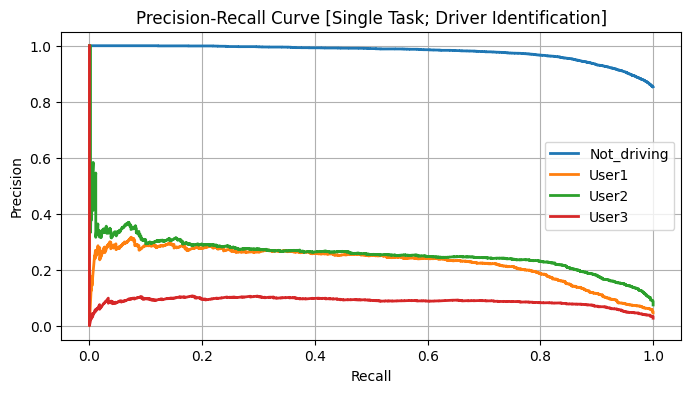

In [18]:
plot_precRec_curve(drv_prec, drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [Single Task; Driver Identification]")

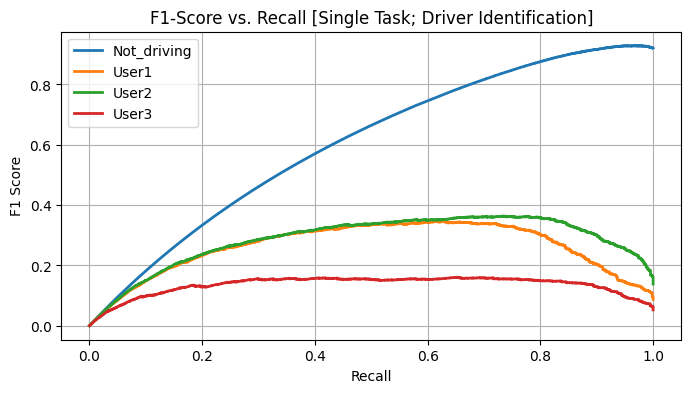

In [19]:
plot_F1rec_curve(drv_rec, drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [Single Task; Driver Identification]")

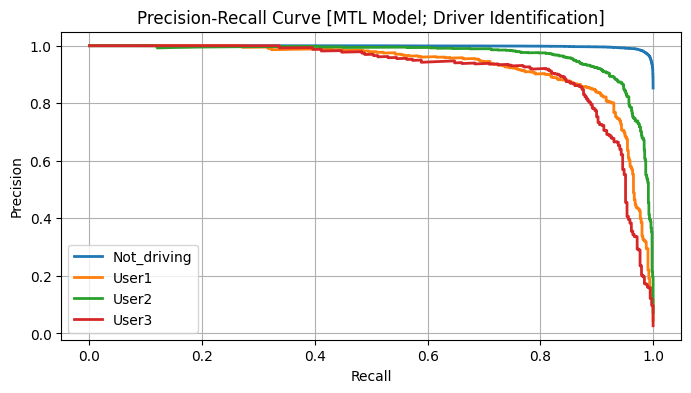

In [20]:
plot_precRec_curve(MTL_drv_prec, MTL_drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [MTL Model; Driver Identification]")

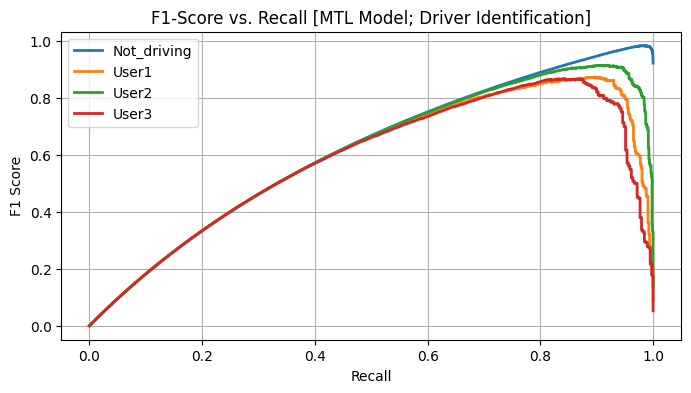

In [21]:
plot_F1rec_curve(MTL_drv_rec, MTL_drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [MTL Model; Driver Identification]")

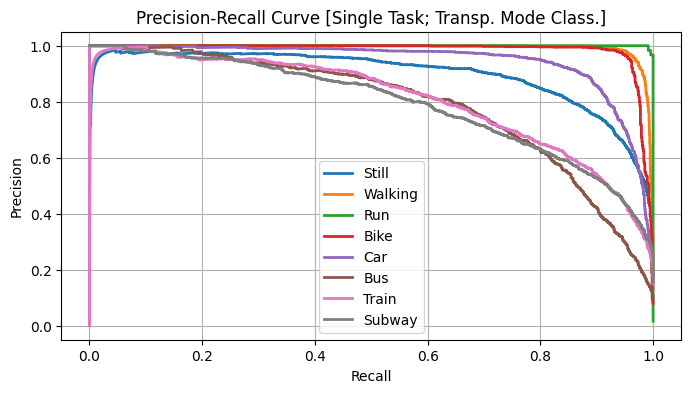

In [22]:
plot_precRec_curve(trp_prec, trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [Single Task; Transp. Mode Class.]")

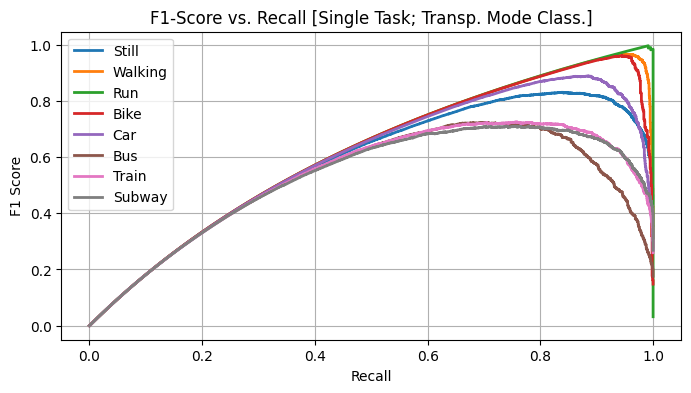

In [23]:
plot_F1rec_curve(trp_rec, trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [Single Task; Transp. Mode Class.]")

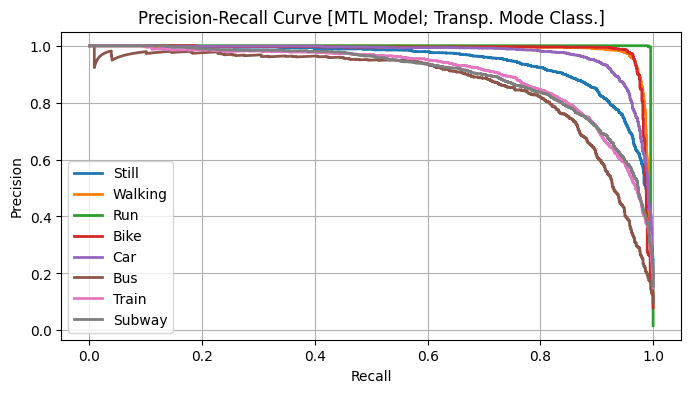

In [24]:
plot_precRec_curve(MTL_trp_prec, MTL_trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [MTL Model; Transp. Mode Class.]")

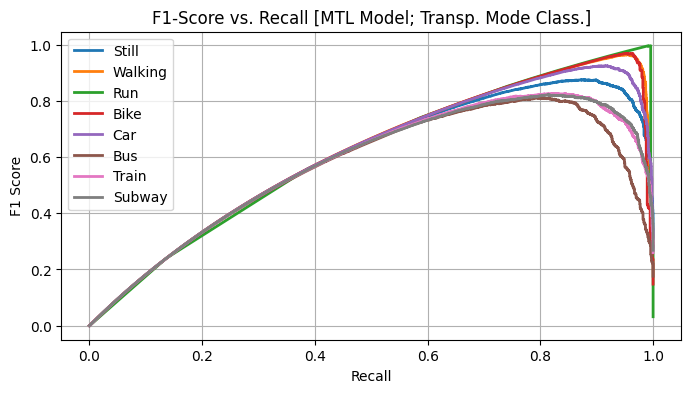

In [25]:
plot_F1rec_curve(MTL_trp_rec, MTL_trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [MTL Model; Transp. Mode Class.]")

**Plotting Learning Curves and Accuracy Curves**

In [26]:
from src.utils import read_Hist

In [27]:
drv_list = ["./model_checkpoint/seed_192_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_117_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_47_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_172_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/run3_driver1D_ResNet50GRU_history.npy"]

trp_hist = ["./model_checkpoint/seed_192_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_117_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_47_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_172_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/run2_40epochs_transpMode_BiLSTM_history.npy"]

MTL_hist = ["./model_checkpoint/seed_47_MTL_model_history.npy",
            "./model_checkpoint/seed_172_MTL_model_history.npy",
            "./model_checkpoint/run1_MTL_model_history.npy",
            "./model_checkpoint/seed_192_MTL_model_history.npy",
            "./model_checkpoint/seed_117_MTL_model_history.npy"]

DRV_tr_loss, DRV_tr_acc, DRV_val_loss, DRV_val_acc = read_Hist().get_trVal_loss_acc(drv_list)
TRP_tr_loss, TRP_tr_acc, TRP_val_loss, TRP_val_acc = read_Hist().get_trVal_loss_acc(trp_hist)
MTL_tr_loss, MTL_tr_acc_TRP, MTL_tr_acc_DRV, MTL_val_loss, MTL_val_acc_TRP, MTL_val_acc_DRV = read_Hist().get_trVal_loss_acc(MTL_hist, MTL=True)

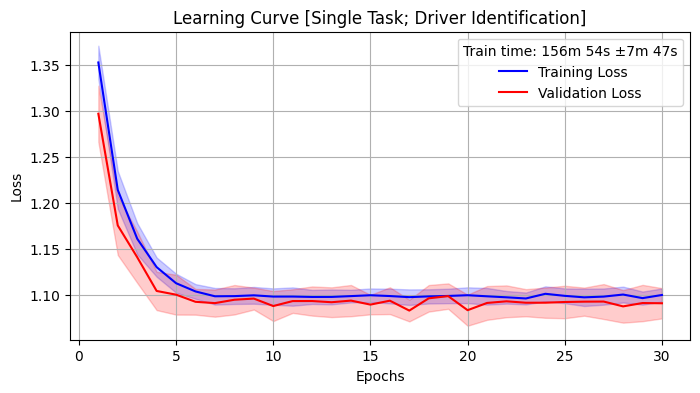

In [28]:
plot_learning_curve(DRV_tr_loss, DRV_val_loss, title='Learning Curve [Single Task; Driver Identification]', legend_text='Train time: 156m 54s ±7m 47s')

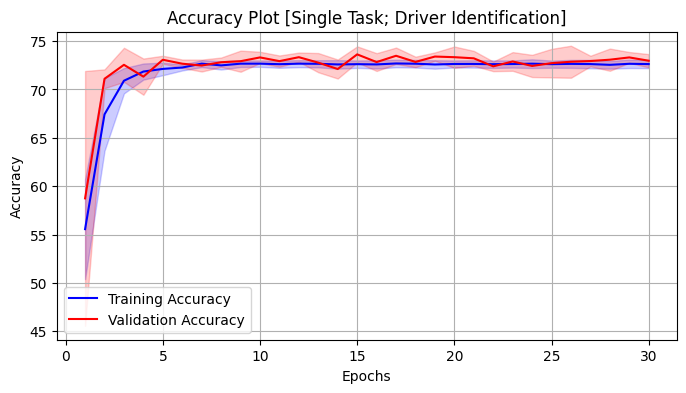

In [29]:
plot_accuracy(DRV_tr_acc, DRV_val_acc, title='Accuracy Plot [Single Task; Driver Identification]', legend_text='')

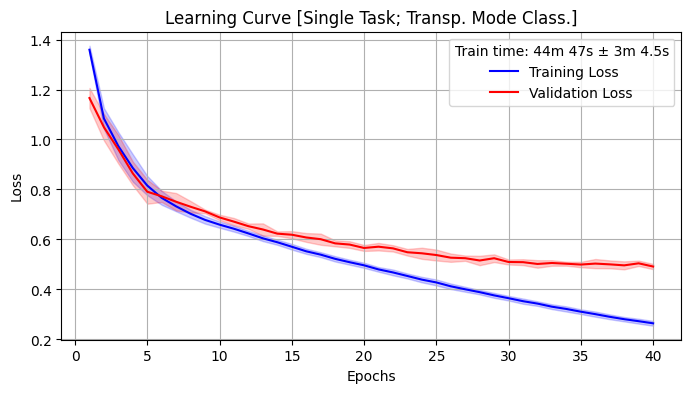

In [30]:
plot_learning_curve(TRP_tr_loss, TRP_val_loss, title='Learning Curve [Single Task; Transp. Mode Class.]', legend_text='Train time: 44m 47s ± 3m 4.5s')

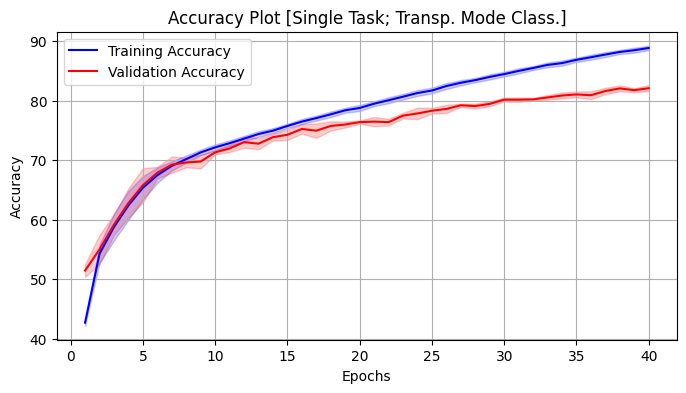

In [31]:
plot_accuracy(TRP_tr_acc, TRP_val_acc, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')

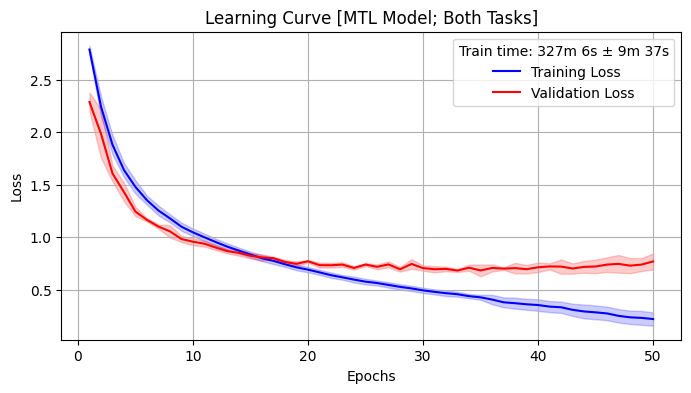

In [32]:
plot_learning_curve(MTL_tr_loss, MTL_val_loss, title='Learning Curve [MTL Model; Both Tasks]', legend_text='Train time: 327m 6s ± 9m 37s')

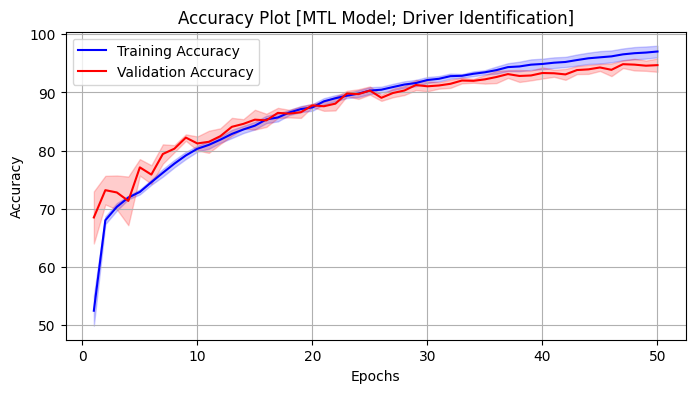

In [33]:
plot_accuracy(MTL_tr_acc_DRV, MTL_val_acc_DRV, title='Accuracy Plot [MTL Model; Driver Identification]', legend_text='')

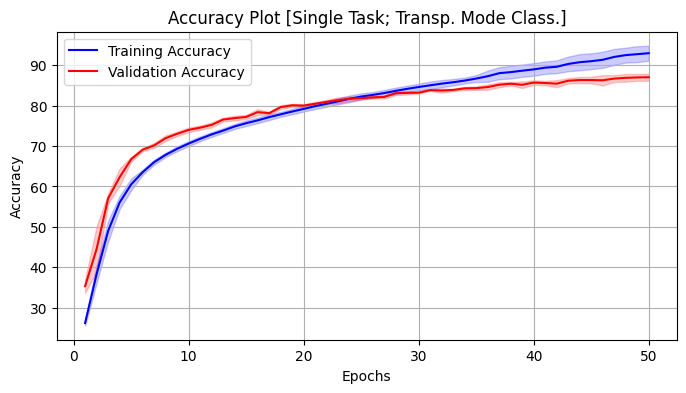

In [34]:
plot_accuracy(MTL_tr_acc_TRP, MTL_val_acc_TRP, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')

### Comparing performance of Single Task and Multitask Model by performing late fusion of their outputs.

In [14]:
print(drv_classes)
print(trp_classes)

['Not_driving' 'User1' 'User2' 'User3']
['Still' 'Walking' 'Run' 'Bike' 'Car' 'Bus' 'Train' 'Subway']


In [15]:
import itertools

In [16]:
# Define the combined classes
combined_classes = []

# Non-driving modes with 'Not_driving'
for mode in trp_classes[trp_classes!='Car']:  # Non-driving modes
      combined_classes.append((mode + '; ' + drv_classes[0]))

# Driving modes with each driver
for driver in drv_classes[1:]:  # Skip 'Not_driving'
      for mode in trp_classes[trp_classes=='Car']:  # Driving modes
            combined_classes.append((mode + '; ' + driver))

# Mismatch dummy label
combined_classes.append(('Mismatch'))
combined_classes = np.array(combined_classes)

In [17]:
[i for i in combined_classes]

['Still; Not_driving',
 'Walking; Not_driving',
 'Run; Not_driving',
 'Bike; Not_driving',
 'Bus; Not_driving',
 'Train; Not_driving',
 'Subway; Not_driving',
 'Car; User1',
 'Car; User2',
 'Car; User3',
 'Mismatch']

Combine both classes together to get the index which are mismatches. Useful when combining probabilities together

In [182]:
ls = list(itertools.product(trp_classes, drv_classes))
comb_class_itr = np.array([(elem[0]+ '; ' +elem[1]) for elem in ls])

# Find the indices of mismatch combinations
mis_idx = np.arange(len(comb_class_itr))[~np.isin(comb_class_itr, combined_classes)]  
# indices of good ones
good_idx = np.arange(len(comb_class_itr))[np.isin(comb_class_itr, combined_classes)]

In [166]:
[i for i in combined_classes]

['Still; Not_driving',
 'Walking; Not_driving',
 'Run; Not_driving',
 'Bike; Not_driving',
 'Bus; Not_driving',
 'Train; Not_driving',
 'Subway; Not_driving',
 'Car; User1',
 'Car; User2',
 'Car; User3',
 'Mismatch']

In [183]:
[i for i in comb_class_itr[good_idx]]

['Still; Not_driving',
 'Walking; Not_driving',
 'Run; Not_driving',
 'Bike; Not_driving',
 'Car; User1',
 'Car; User2',
 'Car; User3',
 'Bus; Not_driving',
 'Train; Not_driving',
 'Subway; Not_driving']

In [194]:
# Create a dictionary to map each element to its index in the desired order
order_dict = {value: index for index, value in enumerate(combined_classes)}
A = comb_class_itr[good_idx]

# Get the sorting indices for A to match B
sorting_indices = np.array([order_dict[element] for element in A])

# Get the sorted array and indices
sorted_A = A[np.argsort(sorting_indices)]
sorted_indices = np.argsort(sorting_indices)

print("Sorted A:", sorted_A)
print("Sorting indices:", sorted_indices)

Sorted A: ['Still; Not_driving' 'Walking; Not_driving' 'Run; Not_driving'
 'Bike; Not_driving' 'Bus; Not_driving' 'Train; Not_driving'
 'Subway; Not_driving' 'Car; User1' 'Car; User2' 'Car; User3']
Sorting indices: [0 1 2 3 7 8 9 4 5 6]


In [189]:
print(combined_classes[:-1])

['Still; Not_driving' 'Walking; Not_driving' 'Run; Not_driving'
 'Bike; Not_driving' 'Bus; Not_driving' 'Train; Not_driving'
 'Subway; Not_driving' 'Car; User1' 'Car; User2' 'Car; User3']


In [18]:
def get_sorting_idx(trp_classes, drv_classes, combined_classes):    
      ls = list(itertools.product(trp_classes, drv_classes))
      comb_class_itr = np.array([(elem[0]+ '; ' +elem[1]) for elem in ls])

      mis_idx = np.arange(len(comb_class_itr))[~np.isin(comb_class_itr, combined_classes)]
      good_idx = np.arange(len(comb_class_itr))[np.isin(comb_class_itr, combined_classes)]

      # Create a dictionary to map each element to its index in the desired order
      order_dict = {value: index for index, value in enumerate(combined_classes)}
      A = comb_class_itr[good_idx]

      # Get the sorting indices for A to match B
      sorting_indices = np.array([order_dict[element] for element in A])

      sorted_indices = np.argsort(sorting_indices)

      return mis_idx, good_idx, sorted_indices

In [138]:
# Ensemble the single-task model predictions
def ensemble_probs_labels(trp_probs, drv_probs, trp_classes, drv_classes, combined_classes):
      ensemble_probs = []
      ensemble_labels = []
      mis_idx, good_idx, sorted_indices = get_sorting_idx(trp_classes, drv_classes, combined_classes)

      for trp_prob, drv_prob in zip(trp_probs, drv_probs):

            # combine each transport mode with a driver label and find the mean proba
            comb_proba_itr = np.mean(list(itertools.product(trp_prob, drv_prob)), axis=1, dtype=np.float32) 
            # get the mean for your mismatch prediction.
            misMatch_proba = np.mean(comb_proba_itr[mis_idx], dtype=np.float32)

            # select the probabilities of importance i.e. good match
            gd_mtch = comb_proba_itr[good_idx]
            gd_mtch = gd_mtch[sorted_indices]
            full_proba = np.append(gd_mtch, misMatch_proba)
            
            full_proba_norm = full_proba/np.sum(full_proba, dtype=np.float64)
            
            # Identify the most probable class for transport and driver
            label = np.argmax(full_proba_norm)
            
            ensemble_probs.append(full_proba_norm)
            ensemble_labels.append(label)

      ensemble_probs = np.array(ensemble_probs)
      ensemble_labels = np.array(ensemble_labels)

      return ensemble_probs, ensemble_labels

In [139]:
SingleTask_probs, SingleTask_labels = ensemble_probs_labels(trp_all_probs, drv_all_probs, trp_classes, drv_classes, combined_classes)
MultiTask_probs, MultiTask_labels = ensemble_probs_labels(MTL_all_probs_TRP, MTL_all_probs_DRV, trp_classes, drv_classes, combined_classes)

In [141]:
combined_classes

array(['Still; Not_driving', 'Walking; Not_driving', 'Run; Not_driving',
       'Bike; Not_driving', 'Bus; Not_driving', 'Train; Not_driving',
       'Subway; Not_driving', 'Car; User1', 'Car; User2', 'Car; User3',
       'Mismatch'], dtype='<U20')

In [142]:
np.where(MultiTask_labels == 8)

(array([   13,    22,    28, ..., 14388, 14433, 14448], dtype=int64),)

In [143]:
MultiTask_probs[13].sum()

1.0

In [144]:
MTL_all_probs_DRV[13].sum()

1.0

In [145]:
# get number of classes
ens_num_classes = len(np.unique(combined_classes))

# Convert labels to a binary format for each class (One-vs-Rest)
SingleTask_labels_bin = label_binarize(SingleTask_labels, classes=list(range(ens_num_classes)))
MultiTask_labels_bin = label_binarize(MultiTask_labels, classes=list(range(ens_num_classes)))

In [146]:
MultiTask_labels

array([1, 5, 1, ..., 1, 6, 3], dtype=int64)

In [147]:
from src.metrics import calc_metrics

In [148]:
SNG_prec, SNG_rec, SNG_f1 = calc_metrics(SingleTask_probs, SingleTask_labels_bin, ens_num_classes)
MTL_prec, MTL_rec, MTL_f1 = calc_metrics(MultiTask_probs, MultiTask_labels_bin, ens_num_classes)

c:\Users\LEGION\anaconda3\envs\torch-gpu\lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [149]:
from src.plot import plot_precRec_curve, plot_F1rec_curve

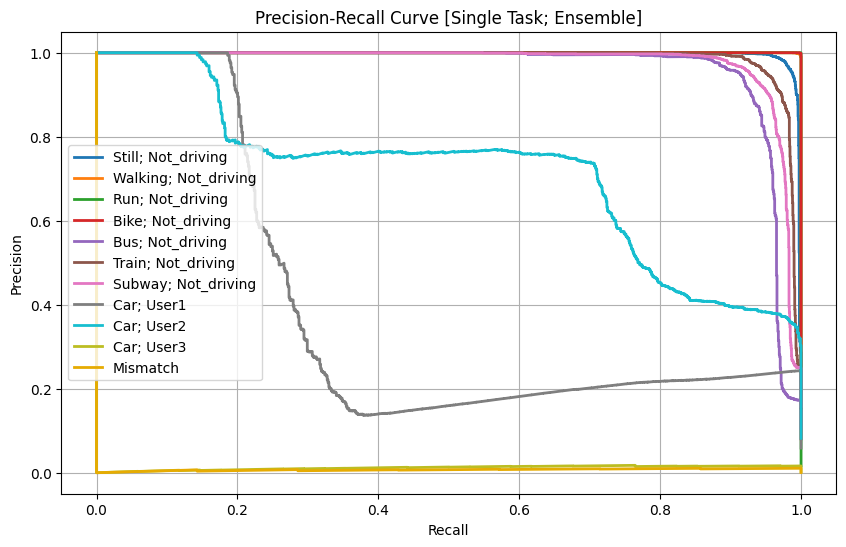

In [151]:
plot_precRec_curve(SNG_prec, SNG_rec, combined_classes, ens_num_classes, figsize=(10,6), title="Precision-Recall Curve [Single Task; Ensemble]")

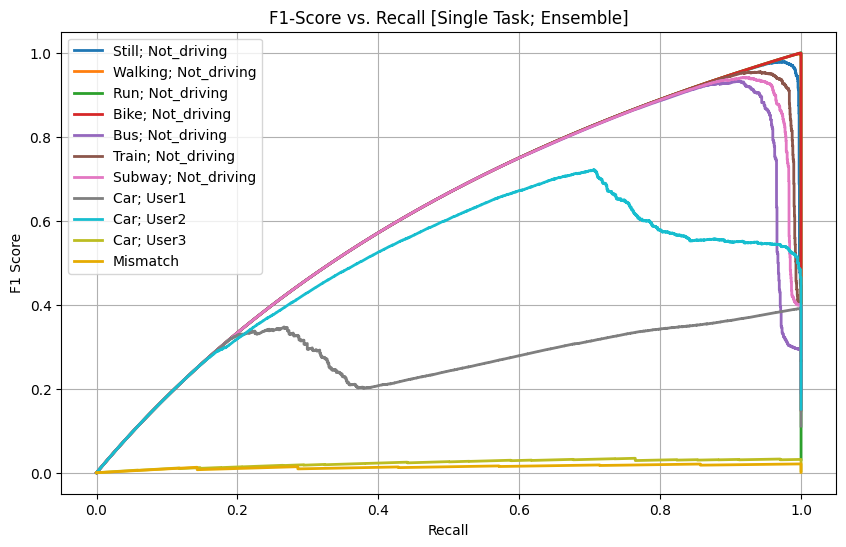

In [152]:
plot_F1rec_curve(SNG_rec, SNG_f1, combined_classes, ens_num_classes, figsize=(10,6), title="F1-Score vs. Recall [Single Task; Ensemble]")

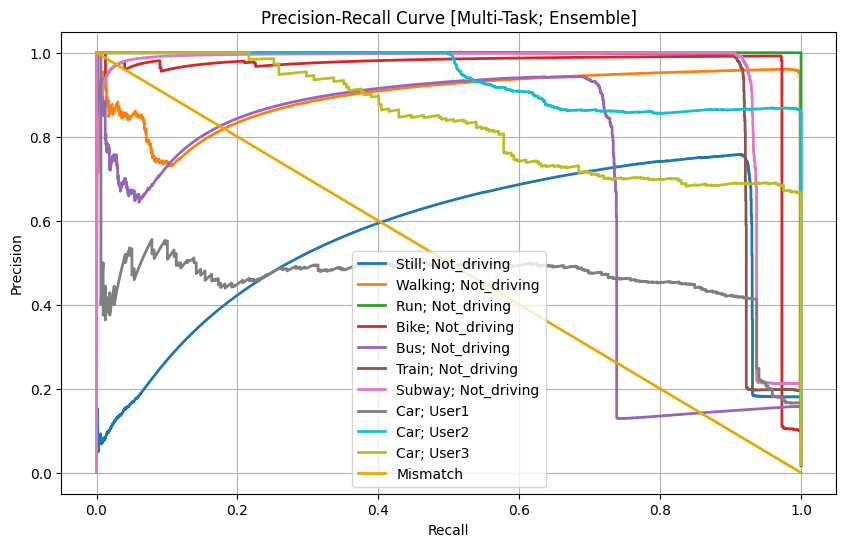

In [153]:
plot_precRec_curve(MTL_prec, MTL_rec, combined_classes, ens_num_classes, figsize=(10,6), title="Precision-Recall Curve [Multi-Task; Ensemble]")

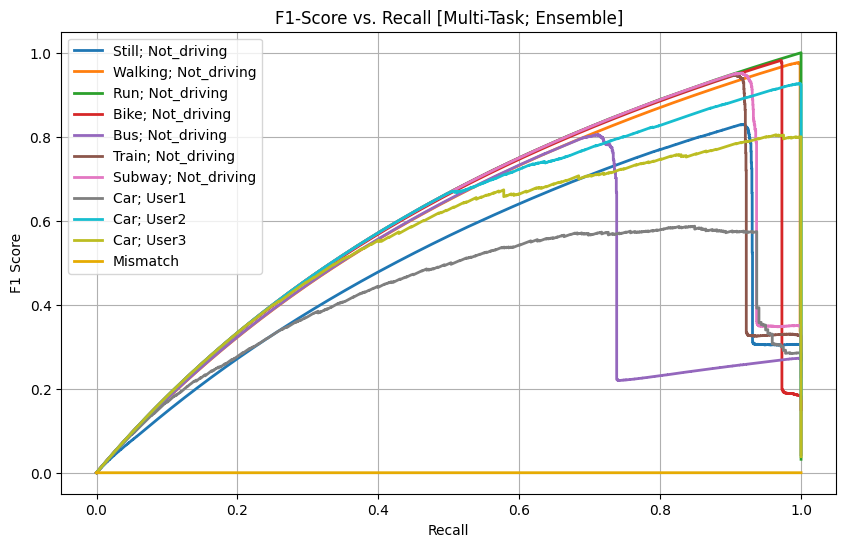

In [154]:
plot_F1rec_curve(MTL_rec, MTL_f1, combined_classes, ens_num_classes, figsize=(10,6), title="F1-Score vs. Recall [Multi-Task; Ensemble]")